# <center>ANALYSIS OF RUSSIAN PROPAGANDA ON TWITTER<center>

# Sentiment analysis

To create this model, I used two already labeled datasets from the **nltk library**. One dataset contains **positive tweets**, and the other has **negative tweets**. I used these datasets for training the model.

## Tweets pre processing

* remove links
* remove @s and #s 
* replace .,!? with "end of sentence" marks to "help" the model
* remove stopwords
* lemmatization

### Creating a corpus of all tweets

In [9]:
corpus_tweet_r = []
for tweet in r_trolls['tweet']:
    corpus_tweet_r.append(tweet)

In [10]:
corpus_tweet_r

['?? President Vladimir Putin: We have to take bold and immediate action. The People\x92s Republics of Donbass have asked Russia for help.  ?? In accordance with Article 51 of the UN Charter I made a decision to carry out a special military operation.  ??  https://t.co/YWm905yxrM  https://t.co/djOn3e2MVk',
 '?? Vladimir Putin: Over the past 30 years we have been patiently trying to come to an agreement with @NATO regarding the principles of equal and indivisible security in Europe.  ?? In response, we faced either cynical deception and lies or attempts at pressure and blackmail.  https://t.co/vzajHJt94Z',
 'President #Putin: For 8 years Russia has been doing everything possible to settle the situation by peaceful means. Everything was in vain. It became impossible to tolerate. We had to stop the atrocity &amp; genocide of millions of people in #Donbass who pinned their hopes on #Russia.  https://t.co/3ujJhSnQom',
 '?? Vladimir Putin: A veritable \x93empire of lies\x94 has been created 

### List of more than 1000 english stopwords

I didn't use the classic stopwords list from nltk because it only includes around 180 stopwords. Instead, I found a more comprehensive list of stopwords containing approximately 1000 words. To access this list, I used the requests library to scrape the data and incorporated it into my analysis. I did this to achieve more accurate and improved results.

In [11]:
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords2 = set(stopwords_list.decode().splitlines())

### Creating a function for processing the tweets

In [12]:
def tweet_process(tweet):
    tweet = re.sub('[^^a-zA-Z]', ' ', tweet) # repleace everything that is not a-zA-Z with ' ' from data[i]
    tweet = tweet.lower() # lower
    tweet = [word for word in tweet.split() if word not in stopwords2] # remove stopwards but from stopords2 list (not nltk lis)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    return(tweet)

### Creating a new corpus of processed tweets

In [13]:
korpus_r = []
for tweet in corpus_tweet_r:
    korpus_r.append(tweet_process(tweet))

In [14]:
korpus_r

[['president',
  'vladimir',
  'putin',
  'bold',
  'action',
  'people',
  'republic',
  'donbas',
  'asked',
  'russia',
  'article',
  'charter',
  'decision',
  'carry',
  'special',
  'military',
  'operation',
  'http',
  'ywm',
  'yxrm',
  'http',
  'djon',
  'mvk'],
 ['vladimir',
  'putin',
  'year',
  'patiently',
  'agreement',
  'nato',
  'principle',
  'equal',
  'indivisible',
  'security',
  'europe',
  'response',
  'faced',
  'cynical',
  'deception',
  'lie',
  'attempt',
  'pressure',
  'blackmail',
  'http',
  'vzajhjt'],
 ['president',
  'putin',
  'year',
  'russia',
  'settle',
  'situation',
  'peaceful',
  'vain',
  'impossible',
  'tolerate',
  'atrocity',
  'amp',
  'genocide',
  'million',
  'people',
  'donbas',
  'pinned',
  'hope',
  'russia',
  'http',
  'ujjhsnqom'],
 ['vladimir',
  'putin',
  'veritable',
  'empire',
  'lie',
  'created',
  'inside',
  'year',
  'satellite',
  'obediently',
  'parrot',
  'slightest',
  'pretext',
  'imitate',
  'behavio

## Building the model (Naive Bayes classifier)

### Preparing the labeled data

In [15]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

### Examples of positive/negative tweets

In [16]:
print(all_positive_tweets[15])
print(all_negative_tweets[13])

Laying out a greetings card range for print today - love my job :-)
I'm so tired hahahah :(


### Train test spliting

In [17]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

### Creating a frequency dictionary

The frequency dictionary provides insights into the frequency of each word in the given tweets list for each corresponding label or category in the list. The dictionary stores word-frequency pairs, where the keys are tuples containing two elements: the word itself and the label (y value) associated with the tweet containing that word. The values in the dictionary represent the frequency count of each word for each label.

In [18]:
def create_frequency(tweets, ys):
    
    freq_d = {}
    
    for tweet, y in zip(tweets, ys):
        for word in tweet_process(tweet):
            
            pair = (word, y)
            
            if pair in freq_d:
                freq_d[pair] += 1
            else:
                freq_d[pair] = freq_d.get(pair, 1) 
    
    return freq_d

In [19]:
# testing

tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]

freq_d = create_frequency(tweets, ys)
print(freq_d)

{('happy', 1): 1, ('tricked', 0): 1, ('sad', 0): 1, ('tired', 0): 2}


In [20]:
# building the freqs dictionary

freqs = create_frequency(train_x, train_y)

### Naive Bayes classifier

The code below presents a function designed to train a Naive Bayes classifier for binary classification tasks using word frequencies from labeled tweets. The function takes as input a dictionary containing word-frequency pairs, along with the training data consisting of tweets and their corresponding labels. During the training process, the function calculates the frequency of each word in positive and negative tweets and then computes the prior probabilities for both classes. The log-likelihood of each word being associated with positive or negative sentiment is calculated, and these parameters, namely logprior (logarithm of prior probabilities) and loglikelihood (logarithm of likelihoods), are returned as the trained classifier's outputs.

In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    
    loglikelihood = {}
    logprior = 0
    
    # computing the number of unique words in vocab
    unique_words = set([pair[0] for pair in freqs.keys()])
    V = len(unique_words)
    
    # N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        
        # geting N_pos and N_get
        if pair[1] > 0:
            N_pos += freqs[(pair)]
            
        else:
            N_neg += freqs[(pair)]
            
    # the number of tweets
    D = train_y.shape[0]
    
    # the number of positive tweets
    D_pos = sum(train_y)
    
    # the number of negative tweets
    D_neg = D - sum(train_y)
    
    # logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # for each unqiue word
    for word in unique_words:
        
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)
        # computing the probability that word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V) 
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos/p_w_neg) # computing the log likelihood of the word
        
    return logprior, loglikelihood

In [22]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
16303


In [23]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    word_l = tweet_process(tweet)
    p = 0 # initialize probability to zero
    p += logprior # adding the logprior

    for word in word_l:
        # geting log likelihood of each keyword
        if  word in loglikelihood:
            p += loglikelihood[word]

    return p

In [24]:
# testing my function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great', 'bad bad bad bad']:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

I am happy -> 1.97
I am bad -> -1.28
this movie should have been great. -> 2.00
great -> 2.11
great great -> 4.21
great great great -> 6.32
great great great great -> 8.42
bad bad bad bad -> -5.12


### Predicting sentiment of tweets

In [25]:
r_trolls['tweet'] = r_trolls['tweet'].astype('string') 
my_list2 = r_trolls['tweet'].tolist()

In [26]:
p_list2 = []
for tweet in my_list2:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    p_list2.append(p)
    
df2 = pd.Series(p_list2)
ndf2 = df2.to_frame(name = 'p')

In [27]:
r_trolls['sentiment'] = p_list2

In [28]:
r_trolls['sentiment'].describe().transpose()

count    19790.000000
mean        -0.071452
std          2.090736
min        -14.421538
25%         -1.151748
50%          0.000000
75%          1.039356
max         19.188242
Name: sentiment, dtype: float64

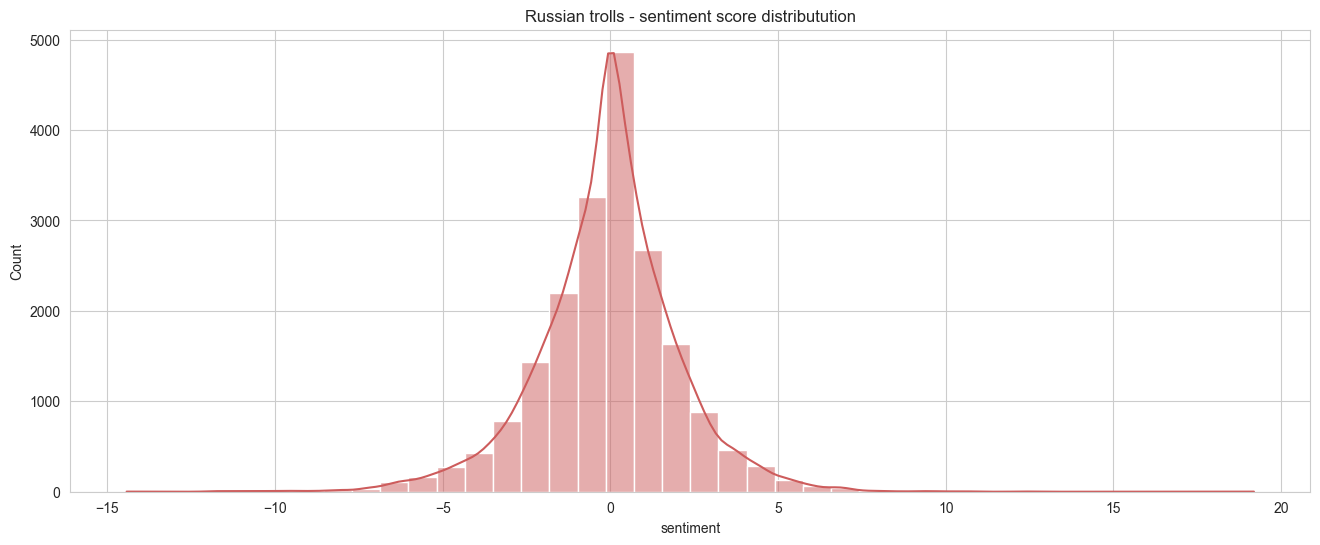

In [29]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

fig, axs = plt.subplots(figsize=(16,6))

r = sns.histplot(r_trolls['sentiment'], bins=40, color = 'indianred', kde = True)
r.set_title('Russian trolls - sentiment score distributution')
plt.show()

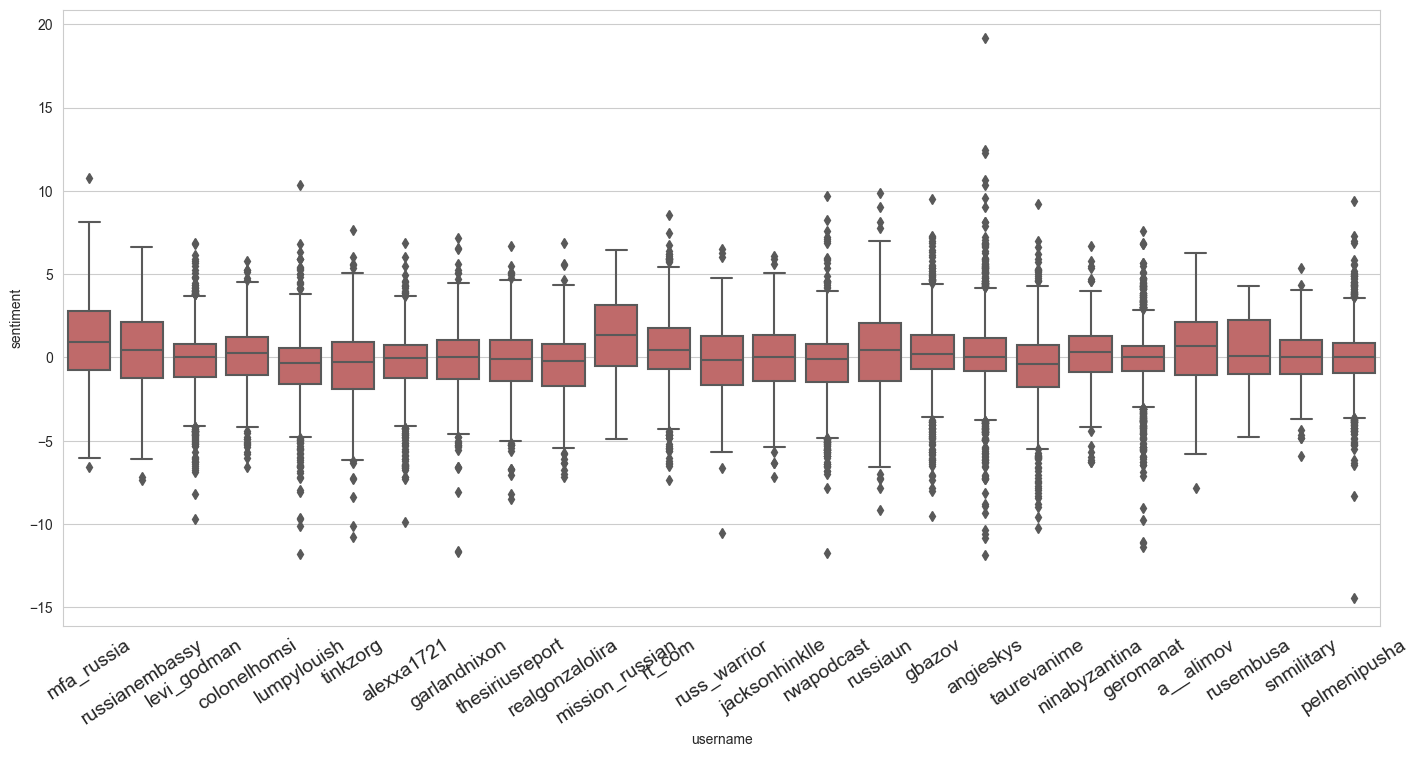

In [30]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

fig = plt.figure(figsize=(17,8))
a = sns.boxplot(x="username", y="sentiment", data=r_trolls, color='indianred')
a.tick_params(axis='x', rotation=33, labelsize = 14)
plt.show()

## Clustering (K-Prototypes)

Furthermore, I wanted to make a clear distinction between accounts that have a negative, positive, or neutral overall sentiment score. For this purpose, I used K-Prototypes.

K-Prototypes is a clustering algorithm that combines K-Means, which is used for numeric data, and K-Modes, which is used for categorical data. It is specifically designed to handle datasets that contain both numerical and categorical variables, making it useful for clustering data with mixed data types.

In [31]:
userssentiment = pd.DataFrame(r_trolls.groupby('username').sentiment.mean())
userssentiment.reset_index(inplace = True)

In [32]:
from sklearn import preprocessing
users = userssentiment.copy()
scaler = preprocessing.StandardScaler()
users.sentiment = scaler.fit_transform(users[['sentiment']])

In [33]:
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=3, init='Cao')
clusters = kproto.fit_predict(users, categorical=[0])
#join data with labels 
labels = pd.DataFrame(clusters)
labeledUsers = pd.concat((userssentiment,labels),axis=1)
labeledUsers = labeledUsers.rename({0:'labels'},axis=1)

In [34]:
df1 = labeledUsers[labeledUsers.labels == 0]
df2 = labeledUsers[labeledUsers.labels == 1]
df3 = labeledUsers[labeledUsers.labels == 2]

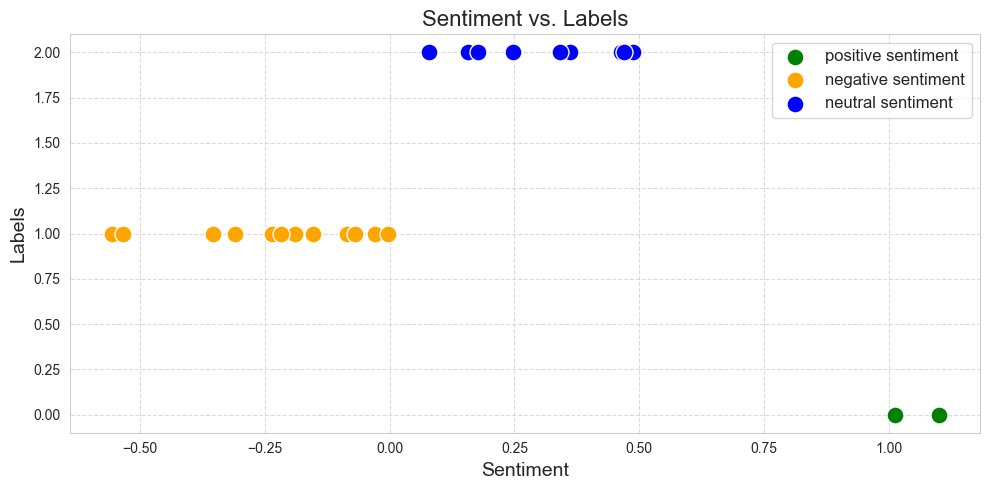

In [37]:
plt.figure(figsize=(10, 5))
ax = plt.gca()

sns.scatterplot(x='sentiment', y='labels', data=df1, color='green', s=150, label='positive sentiment')

sns.scatterplot(x='sentiment', y='labels', data=df2, color='orange', s=150, label='negative sentiment')

sns.scatterplot(x='sentiment', y='labels', data=df3, color='blue', s=150, label='neutral sentiment')

plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Labels', fontsize=14)
plt.title('Sentiment vs. Labels', fontsize=16)

plt.legend(loc='upper right', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7) # customizing the grid

plt.tight_layout()
plt.show()

### Accounts with an overall positive score of sentiment

In [38]:
labeledUsers[labeledUsers['labels'] == 0]

,username,sentiment,labels
10,mfa_russia,1.012374,0
11,mission_russian,1.099113,0


### Accounts with an overall negative score of sentiment

In [39]:
labeledUsers[labeledUsers['labels'] == 1]

,username,sentiment,labels
1,alexxa1721,-0.309326,1
4,garlandnixon,-0.153523,1
6,geromanat,-0.084410,1
7,jacksonhinklle,-0.069218,1
8,levi_godman,-0.189526,1
9,lumpylouish,-0.540474,1
13,pelmenipusha,-0.028483,1
14,realgonzalolira,-0.552307,1
17,russ_warrior,-0.236020,1
20,rwapodcast,-0.353696,1


### Accounts with an overall neutral score of sentiment

In [40]:
labeledUsers[labeledUsers['labels'] == 2]

,username,sentiment,labels
0,a__alimov,0.463690,2
2,angieskys,0.157342,2
3,colonelhomsi,0.079445,2
5,gbazov,0.247097,2
12,ninabyzantina,0.176704,2
15,rt_com,0.486371,2
16,rusembusa,0.361517,2
18,russianembassy,0.469196,2
19,russiaun,0.340534,2
